# State dependent perturbation of the parametron

In this example, we will show how we can understand the bifurcation lines of two coupled duffing resonotors with a global parametric drive.

We load the following packages into our environment:

In [1]:
using HarmonicBalance;

HB = HarmonicBalance;
using HarmonicBalance: Result, OrderedDict

using Plots
c = :viridis;
cticks = 0:9;
crange = (0, 9);

Later, we will need to classification the solutions of our perturbations. Hence, we define our own classification function:

In [2]:
function my_classify_default!(result)
    my_classify_solutions!(result, HB.is_physical, "physical")
    my_classify_solutions!(result, HB.is_stable, "stable")
    HB.order_branches!(result, ["physical", "stable"]) # shuffle the branches to have relevant
end
function my_classify_solutions!(res::Result, f::Function, name::String)
    values = my_classify_solutions(res, f)
    res.classes[name] = values
end
function my_classify_solutions(res::Result, f::Function)
    values = similar(res.solutions, BitVector)
    for (idx, soln) in enumerate(res.solutions)
        values[idx] = [
            f(my_get_single_solution(res, index=idx, branch=b), res) for
            b = 1:length(soln)
        ]
    end
    values
end
function my_get_single_solution(res; index, branch)
    sol = get_single_solution(res, index=index, branch=branch)
    merge(sol, Dict(ua => A[CartesianIndex(index)][1], va => A[CartesianIndex(index)][2]))
end

my_get_single_solution (generic function with 1 method)

The system in in the normal mode basis is given by:

In [3]:
@variables t xs(t) xa(t);
@variables ω0 ω λ α J γ;
equations = [
    d(d(xs, t), t) +
    (ω0^2 - J - λ * cos(2 * ω * t)) * xs +
    γ * d(xs, t) +
    (α / 4) * (xs^3 + 3 * xa^2 * xs),
    d(d(xa, t), t) +
    (ω0^2 + J - λ * cos(2 * ω * t)) * xa +
    γ * d(xa, t) +
    (α / 4) * (xa^3 + 3 * xs^2 * xa),
]
system = DifferentialEquation(equations, [xs, xa])

System of 2 differential equations
Variables:       xs(t), xa(t)
Harmonic ansatz: xs(t) => ;   xa(t) => ;   

Differential(t)(Differential(t)(xs(t))) + Differential(t)(xs(t))*γ + xs(t)*(-J - cos(2t*ω)*λ + ω0^2) + (1//4)*(xs(t)^3 + 3xs(t)*(xa(t)^2))*α ~ 0
Differential(t)(Differential(t)(xa(t))) + Differential(t)(xa(t))*γ + xa(t)*(J - cos(2t*ω)*λ + ω0^2) + (1//4)*(3(xs(t)^2)*xa(t) + xa(t)^3)*α ~ 0


We will consider the averaged system were both the symmetric and antisymmetric mode are expanded in the frequency $\omega$:

In [4]:
add_harmonic!(system, xs, ω)
add_harmonic!(system, xa, ω)
harmonic_normal = get_harmonic_equations(system);

We compute the steady states of the system for a range of $\omega$ and $\lambda$ values:

In [5]:
res = 80
fixed_ωλ = Dict(ω0 => 1.0, α => 1.0, J => 0.005, γ => 0.005) |> OrderedDict
varied_ωλ = (ω => range(0.99, 1.01, res), λ => range(1e-6, 0.03, res)) |> OrderedDict

method = TotalDegree()
result_ωλ_normal = get_steady_states(
    harmonic_normal,
    method,
    varied_ωλ,
    fixed_ωλ,
);

Solving via TotalDegree homotopy ... 100%|██████████████████████████████████████████████████| Time: 0:00:45


We plot the number of stable steady states in the $\omega-\lambda$ plane using:

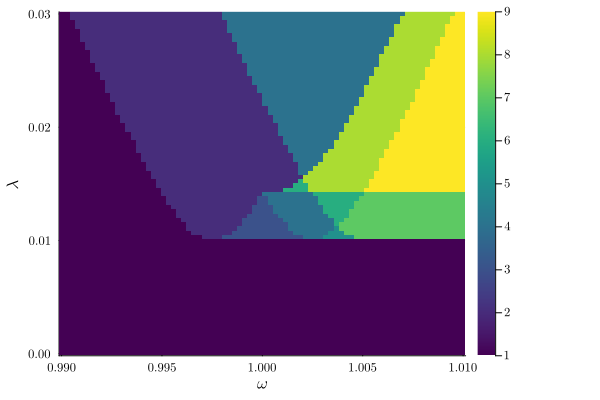

In [6]:
plot_phase_diagram(result_ωλ_normal, class="stable")

We consider the uncoupled system by removing the coupled terms in the equations of motion:

In [7]:
@variables t xa(t);
@variables ω0 ω λ α J;
equations_xa =
    [d(d(xa, t), t) + (ω0^2 + J - λ * cos(2 * ω * t)) * xa + γ * d(xa, t) + (α / 4) * xa^3]
equations_xs =
    [d(d(xs, t), t) + (ω0^2 - J - λ * cos(2 * ω * t)) * xs + γ * d(xs, t) + (α / 4) * xs^3]

system_xa = DifferentialEquation(equations_xa, [xa])
system_xs = DifferentialEquation(equations_xs, [xs])
add_harmonic!(system_xa, xa, ω)
add_harmonic!(system_xs, xs, ω)
harmonic_antisym = get_harmonic_equations(system_xa);
harmonic_sym = get_harmonic_equations(system_xs);

The uncoupled antisysmmetic mode will have a typical parametron phase diagram around the frequency $\omega_a$. We are interested in the non-zero amplitude solution which we will consider as the zeroth orcer in the perturbation.

Solving for 6400 parameters...  64%|████████████▊       |  ETA: 0:00:00
  # parameters solved:  4090


Solving for 6400 parameters... 100%|████████████████████| Time: 0:00:00
  # parameters solved:  6400
  # paths tracked:      32000


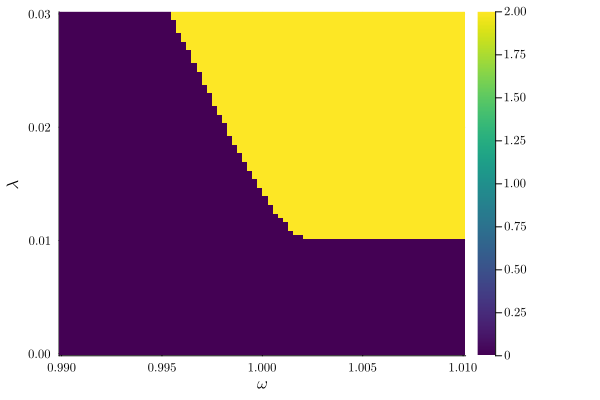

In [8]:
result_ωλ_antisym =
    get_steady_states(harmonic_antisym, varied_ωλ, fixed_ωλ);

classify_solutions!(result_ωλ_antisym, "sqrt(u1^2 + v1^2) > 1e-3", "not_zero")
plot_phase_diagram(result_ωλ_antisym, class=["stable","not_zero"])

We filter the non-zero amplitude solution and store it in a matrix $A$:

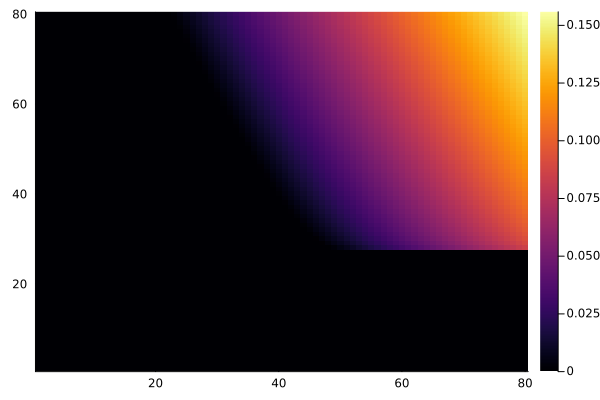

In [9]:
branch_mat = HB._get_mask(result_ωλ_antisym, ["stable", "not_zero"], []) .|> findfirst
A = map(CartesianIndices(result_ωλ_antisym.solutions)) do idx
    branch = branch_mat[idx]
    if isnothing(branch)
        sol = zeros(2)
    else
        sol = real(result_ωλ_antisym.solutions[idx][branch])
    end
    sol
end;
heatmap(map(v -> v[1]^2 + v[2]^2, A)')

The next step is to dress the symmetric mode with the non-zero amplitude solution of the antisymmetric mode. For this we set up a perturbed problem for the symmetric mode:

In [10]:
@variables T u2(T) v2(T) ua va
harmonic_tmp = deepcopy(harmonic_sym)
harmonic_tmp.equations = HB.Symbolics.substitute(
    HB.rearrange_standard(harmonic_normal).equations[1:2],
    Dict(u2 => ua, v2 => va),
)
harmonic_tmp.parameters = push!(harmonic_tmp.parameters, ua, va)
prob = HarmonicBalance.Problem(harmonic_tmp)

2 algebraic equations for steady states
Variables: u1, v1
Parameters: ω, J, λ, ω0, α, γ, ua, va
Symbolic Jacobian: true


We will sweep over the $\omega-\lambda$ plane and substitute the non-zero amplitude solution of the antisymmetric mode into the coupled equations of thesymmetric mode.

In [11]:
all_keys = cat(collect(keys(varied_ωλ)), collect(keys(fixed_ωλ)), dims=1)
permutation =
    filter(
        !isempty,
        [findall(x -> isequal(x, par), all_keys) for par in prob.parameters],
    ) .|> first

param_ranges = collect(values(varied_ωλ))
input_array = collect(Iterators.product(param_ranges..., values(fixed_ωλ)...))
input_array = getindex.(input_array, [permutation])
input_array = HB.tuple_to_vector.(input_array)
input_array =
    map(idx -> push!(input_array[idx], A[idx]...), CartesianIndices(input_array))

80×80 Matrix{Vector{Float64}}:
 [0.99, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]      …  [0.99, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.990253, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.990253, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.990506, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.990506, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.990759, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.990759, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.991013, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.991013, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.991266, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]  …  [0.991266, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.991519, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.991519, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.991772, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.991772, 0.005, 0.03, 1.0, 1.0, 0.005, 0.0, 0.0]
 [0.992025, 0.005, 1.0e-6, 1.0, 1.0, 0.005, 0.0, 0.0]     [0.992025, 0.005, 0.03, 1.0, 1.0, 0.005, 0.

Solving for the steady states of the dressed symmetric mode:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


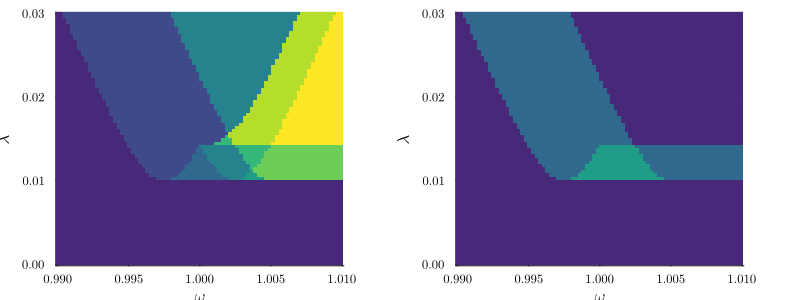

In [12]:
function solve_perturbed_system(prob, input)
    result_full = HB.ProgressMeter.@showprogress map(input_array) do input
        HB.HomotopyContinuation.solve(
            prob.system;
            start_system=:total_degree,
            target_parameters=input,
            threading=false,
            show_progress=false,
        )
    end

    rounded_solutions = HB.HomotopyContinuation.solutions.(result_full)
    solutions = HB.pad_solutions(rounded_solutions)

    J_variables = cat(prob.variables, collect(keys(varied_ωλ)), [ua, va], dims=1)
    compiled_J = HB.compile_matrix(prob.jacobian, J_variables, rules=fixed_ωλ)
    compiled_J = HB.JacobianFunction(HB.solution_type(solutions))(compiled_J)
    result = HB.Result(solutions, varied_ωλ, fixed_ωλ, prob, Dict(),
    zeros(Int64, size(solutions)...),
    compiled_J, HB.seed(method));

    my_classify_default!(result)
    return result
end
result = solve_perturbed_system(prob, input_array)

plot(
    plot_phase_diagram(result_ωλ_normal, class=["stable"],colorbar=false),
    plot_phase_diagram(result, class=["stable"],colorbar=false),
    clim=crange,
    size=(800, 300),
)

We see that the perturbed symmetirc mode gives the same bifurcation lines as the full system. Hence, the nonlinear normal mode coupling instantiates a new bifurcation in the system. For more detail consider reading the paper [Ameye et al. (arXiv:2501.08793)](https://www.arxiv.org/abs/2501.08793) where we explore and explain the bifurcation line of the coupled Kerr/Duffing parametric oscillators.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*